# How to tune the learning rate of a stochastic optimization
**Configuring the stochastic optimizer by requesting the cost history from the optimization results**

Boulder Opal provides a highly flexible optimization engine for general-purpose optimization.
It can be directly applied to model-based control optimization and for model-based system identification.

The optimization engine from Boulder Opal allows you to tune the parameters of your optimization.
You can use the additional information provided by the history of costs obtained during the course of the optimization to see which choices of these parameters are the best for your purposes.

This user guide will show how to use the cost histories returned by the optimization engine to select the learning rate of the [Adam stochastic optimizer](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam).
For general instructions about how to use the stochastic optimizer, see the user guide [How to optimize controls robust to strong noise sources](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-controls-robust-to-strong-noise-sources).
For an example of how to use the cost history to tune parameters of a non-stochastic optimization, see the user guide [How to tune the parameters of an optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-tune-the-parameters-of-an-optimization).

## Summary workflow
### 1. Define the computational graph

The Boulder Opal optimization engine expresses all optimization problems as [data flow graphs](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal), which you can create with `boulderopal.Graph`.
The methods of the graph object allow you to represent the mathematical structure of the problem that you want to solve.

### 2. Execute optimization and retrieve cost history

You can calculate a stochastic optimization from an input graph using the `boulderopal.run_stochastic_optimization` function.
This function allows you to retrieve the history of all the costs for each step of the optimization, or the history of the best value of the costs up to each iteration.
You can request the history of costs with the `cost_history_scope` argument.

### 3. Compare the cost histories for different choices of the learning rate

You can retrieve the list of costs by looking at the `"cost_history"` element in the dictionary returned by the optimization.
By plotting these results, you can then verify which choices of parameters resulted in costs that stagnated, and which ones kept improving with each iteration.
You can then keep refining the choices, and requesting more iterations for the parameter values whose costs did not stagnate.

### 4. Restart the optimization for the most successful choice of the learning rate

Together with the output of the optimization, the stochastic optimizer returns the `"state"` of the optimizer at the last iteration of the optimization.
You can use this state as a replacement to the `optimizer` configuration argument when calling the stochastic optimization function, in order to restart the optimization from the same point where the previous optimization had stopped.

## Example: Tuning the learning rate and iteration count for a stochastic optimization

Consider the problem of finding the best drive pulse to create an $X$ gate for a single-qubit system whose Hamiltonian is the following:
$$ H = (1 + \beta) \frac{\Omega_x(t) \sigma_x + \Omega_y(t) \sigma_y}{2} + \frac{\zeta}{2} \sigma_z , $$
where $\sigma_x$, $\sigma_y$, and $\sigma_z$ are the Pauli matrices, $\Omega_x(t)$ and $\Omega_y(t)$ are two drive pulses that you want to optimize, $\beta$ and $\zeta$ are a quasi-static amplitude noise and dephasing noise, respectively, both sampled from a normal distribution.

Suppose that you want to use the stochastic optimizer to find the best pulses to reduce the effect of the noise, but you don't know which value of the learning rate will yield the best result.
In this case, you can run the optimization for different values of the learning rate, and retrieve the history of the best cost for each of them.
By plotting these best costs as a function of the iteration, you can then see which choices of the parameters stagnated at a certain level and which ones kept improving.
For those that kept improving without stagnating, you can increase the iteration count to obtain better results.

The following example shows how to make this comparison for different values of the `learning_rate`, plotting the results of the cost histories.
At the end, we show how to continue the optimization for the learning rate that resulted in the best cost.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

In [2]:
# Define optimization parameters.
omega_max = 2 * np.pi * 25e3  # Hz
duration = 200e-6  # s
segment_count = 80
noise_count = 400

In [3]:
# Create optimization graph.
graph = bo.Graph()

# Define optimizable pulses, start with square pulse.
i_signal = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    duration=duration,
    maximum=omega_max,
    minimum=-omega_max,
    initial_values=np.ones(segment_count) * np.pi / duration,
)
q_signal = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    duration=duration,
    maximum=omega_max,
    minimum=-omega_max,
    initial_values=np.zeros(segment_count),
)
# Create drive term of the Hamiltonian.
drive_term = (
    i_signal * graph.pauli_matrix("X") / 2.0 + q_signal * graph.pauli_matrix("Y") / 2.0
)

# Create amplitude noise realizations.
amplitude_noise = graph.random.normal(
    mean=0, standard_deviation=0.2, shape=(noise_count, 1)
)
amplitude_noise_pwc = graph.constant_pwc(
    constant=amplitude_noise, duration=duration, batch_dimension_count=1
)

# Create dephasing noise realizations.
dephasing_noise = graph.random.normal(
    mean=0, standard_deviation=2e4, shape=(noise_count, 1)
)
dephasing_noise_pwc = graph.constant_pwc(
    constant=dephasing_noise, duration=duration, batch_dimension_count=1
)
dephasing_term = dephasing_noise_pwc * graph.pauli_matrix("Z")

# Define batch of infidelities.
hamiltonian = (1 + amplitude_noise_pwc) * drive_term + dephasing_term
infidelities = graph.infidelity_pwc(
    hamiltonian=hamiltonian, target=graph.target(graph.pauli_matrix("X"))
)

# Calculate cost as the average of the infidelities.
cost = graph.sum(infidelities) / noise_count
cost.name = "cost"

In [4]:
# Run optimization for each value of the learning rate.

learning_rates = [0.2, 0.1, 0.08, 0.04, 0.01]
results = {}
with bo.cloud.group_requests():
    for learning_rate in learning_rates:
        results[learning_rate] = bo.run_stochastic_optimization(
            graph=graph,
            cost_node_name="cost",
            output_node_names=["cost"],
            optimizer=bo.stochastic.Adam(learning_rate),
            cost_history_scope="HISTORICAL_BEST",
            iteration_count=4000,
        )

Your task (action_id="1829148") has started.
Your task (action_id="1829148") has completed.
Your task (action_id="1829149") has completed.
Your task (action_id="1829150") has completed.
Your task (action_id="1829151") has completed.
Your task (action_id="1829152") has completed.


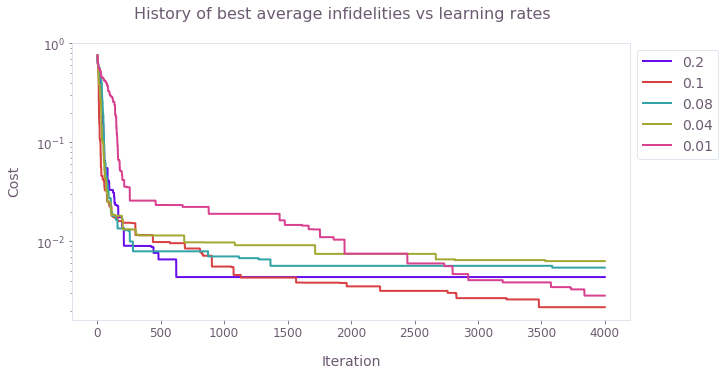

In [5]:
# Plot best cost history for each value of the learning rate.
qv.plot_cost_histories(
    [result["cost_history"]["historical_best"] for result in results.values()],
    labels=[str(learning_rate) for learning_rate in results],
    y_axis_log=True,
)
plt.suptitle("History of best average infidelities vs learning rates")
plt.show()

In [6]:
# Continue optimization for the learning rate with the best cost.
best_learning_rate, best_result = min(list(results.items()), key=lambda x: x[1]["cost"])

continued_results = bo.run_stochastic_optimization(
    graph=graph,
    cost_node_name="cost",
    output_node_names=["cost"],
    optimizer=best_result["state"],
    cost_history_scope="HISTORICAL_BEST",
    iteration_count=4000,
)

Your task (action_id="1829153") has started.
Your task (action_id="1829153") has completed.


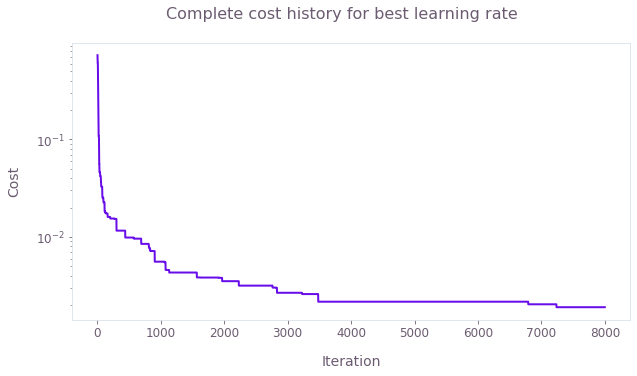

In [7]:
# Get the complete history of best cost values.
complete_cost_history = np.minimum.accumulate(
    best_result["cost_history"]["historical_best"]
    + continued_results["cost_history"]["historical_best"]
)

# Plot complete graph of cost history.
qv.plot_cost_histories(list(complete_cost_history), y_axis_log=True)
plt.suptitle("Complete cost history for best learning rate")
plt.show()